# Описание проекта

Допустим, мы работаем в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Построим модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

### Описание данных

#### Признаки

- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);

#### Целевой признак

- product — объём запасов в скважине (тыс. баррелей).

### Условия задачи:

Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).

При разведке региона исследуют 500 точек, из которых выбирают 200 лучших для расчёта прибыли.

Бюджет на разработку скважин в регионе — 10 млрд рублей.

Один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

### Краткий план работы

1. Загрузка и подготовка данных

2. Обучить и проверить модель для каждого региона:

    2.1. Разбивка данных на обучающую и валидационную выборки в соотношении 75:25.
    
    2.2. Обучить модель и сделать предсказания на валидационной выборке.
    
    2.3. Сохранить предсказания и правильные ответы на валидационной выборке.
    
    2.4. Вывести средний запас предсказанного сырья и RMSE модели.
    
    2.5. Проанализировать результаты.
    
3. Подготовка к расчёту прибыли:

    3.1. Все ключевые значения для расчётов сохранить в отдельных переменных.
    
    3.2. Расчет достаточного объёма сырья для безубыточной разработки новой скважины. Сравнить полученный объём сырья со средним запасом в каждом регионе.
    
    3.3. Сделать выводы по этапу подготовки расчёта прибыли.
    
4. Написать функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:

    4.1. Выбрать скважины с максимальными значениями предсказаний. Количество скважин зависит от бюджета компании и стоимости разработки одной скважины.
    
    4.2. Просуммировать целевое значение объёма сырья, соответствующее этим предсказаниям.
    
    4.3. Расчет прибыль для полученного объёма сырья.
    
5. Расчет рисков и прибыли для каждого региона:

    5.1. Применить технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
    
    5.2. Найти среднюю прибыль, 95%-й доверительный интервал и риск убытков.
    
    5.3. Сделать выводы: предложить регион для разработки скважин.

# 1. Загрузка и подготовка данных

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

У нас имеются три файла, загрузим их, затем рассмотрим по отдельности на предмет наличия аномалий

In [20]:
gd1 = pd.read_csv('/datasets/geo_data_0.csv')
gd2 = pd.read_csv('/datasets/geo_data_1.csv')
gd3 = pd.read_csv('/datasets/geo_data_2.csv')

In [21]:
gd1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [22]:
gd1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


Пропусков в данных нет, но видно, что третий признак (f2) имеет больший разброс, чем другие. На этапе подготовки модели можно отмасштабировать его, чтобы улучшить качество.

In [23]:
gd1.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


Далее рассмотрим разброс признаков, использую одну функцию для всех трех регионов. По оси абсцисс отложены признаки, по оси ординат - целевой признак. Ввиду большого объема данных используем hexbin (scatter просто дает большое жирное пятно).

In [24]:
def Hexes(df, gridsize=50):
    """
    Рисовалка. На вход принимает DataFrame и опционально желаемый размер корзины
    """
    plt.figure(figsize=(18, 5))
    plt.subplot(131)
    plt.hexbin(df.f0, df['product'], gridsize=gridsize)
    plt.ylabel('product')
    plt.xlabel('f0')
    plt.subplot(132)
    plt.hexbin(df.f1, df['product'], gridsize=gridsize)
    plt.xlabel('f1')
    plt.subplot(133)
    plt.hexbin(df.f2, df['product'], gridsize=gridsize)
    plt.xlabel('f2')
    plt.show()

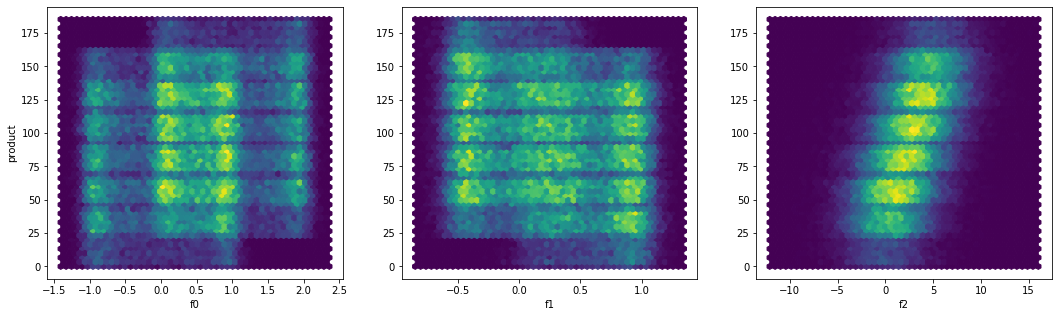

In [25]:
Hexes(gd1)

У нас данные синтетические, о чем указано в описании проекта, возможно, поэтому, они распределены, скажем так.. необычно. Возможно, не поэтому.

Во всех графиках большинство значений попадают в некоторые группы. К сожалению, поскольку мы ничего не знаем, что это за признаки, нельзя ничего сказать по этим данным. Также можно заметить провал в районе product = 90, как ножом вырезали.. Есть еще несколько таких провалов по х. Также интересно, что и f0, и f1 похожи на две оконных рамы что ли, наложенных друг на друга, только отзеркаленные, у первого распределения отсутствуют данные в левом верхнем и правом нижнем углах, а в f1 наоборот.. Повторюсь, данные синтетические и непонятно, что это значит, но вообще похоже на две группы какие-то, наложенных друг на друга.

Наконец, на третьем графике заметна линейная корреляция.

In [26]:
gd1.f2.corr(gd1['product'])

0.48366328692615307

Т.о., имеется средней степени корреляция между этими признаками

Второй регион:

In [27]:
gd2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [28]:
gd2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


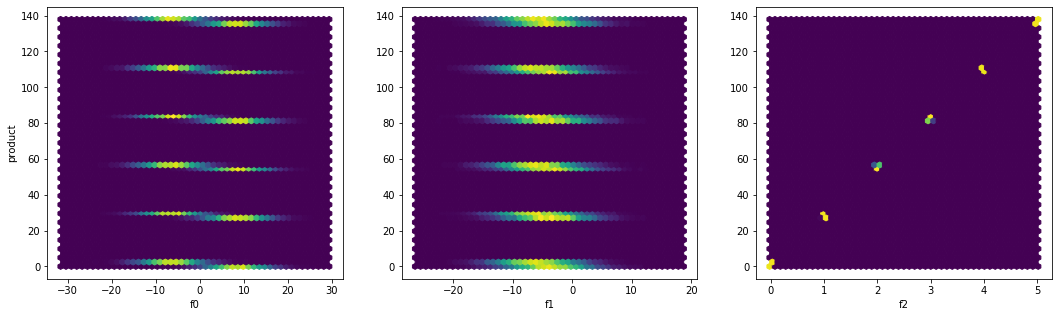

In [29]:
Hexes(gd2)

Я затрудняюсь объяснить формы этих графиков. Видно шесть явных кластеров на всех трех графиках (хотя если присмотреться, даже 12). Возможно, это можно как-то использвать. Можно выделить очевидную корреляцию на третьем графике.

In [30]:
gd2['f2'].corr(gd2['product'])

0.9993969704906548

Здесь прям очень сильная связь.

Третий регион:

In [31]:
gd3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [32]:
gd3.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


In [33]:
gd3.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


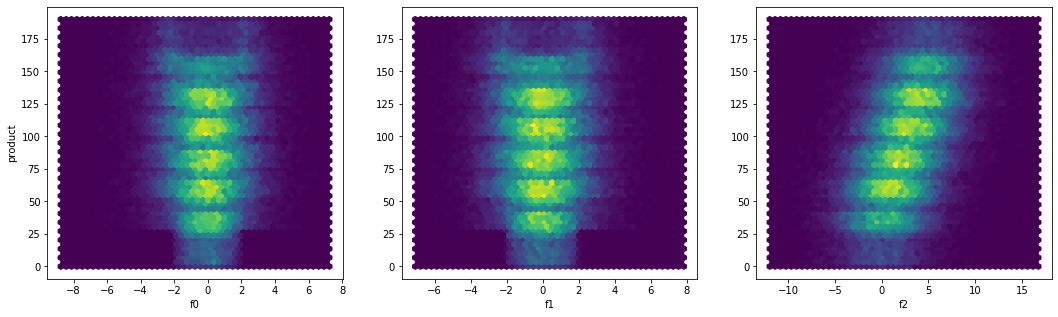

In [34]:
Hexes(gd3)

In [35]:
gd3.f2.corr(gd3['product'])

0.44587109155742066

Тут тоже видно шесть зон концентрации скважин (шестая слабенькая, но разглядеть можно). Первые лва графика похожи на деревья, при |f0| > 2 совсем нет скважин с добычей менее 25 т.т. На третьем графике примерно та же степень корреляции, что и в первом регионе

## Вывод:

Данные весьма необычно распределены в каждом регионе выделяется около шести кластеров - значений, около которых сконцентрированы большинство значений показателя объёма запасов, при этом значения объема на первый взгляд зависят только от признака f2, в то время как для двух других признаков никаких корреляций не наблюдается.

Я считаю, что данные можно применять для обучения модели "как есть", здесь можно было бы только выделить какие-то выбросы, вернее, очень малые и очень большие значения, но, как мне кажется, их не так много, модель и сама с этим справится.

В следующем шаге можно отмасштабировать признаки, посколько масштаб f2 имеет больший разброс в первом и третьем регионе, и наоборот, меньший во втором. Данный регион в целом отличается от других картиной распределения значений признаков, возможно, в дальнейшем будут выявлены какие-то отличия именно для него.

# 2. Обучение и проверка модели

Начнем с разделения данных на обучающие и валидационые выборки.

In [36]:
target1 = gd1['product']
features1 = gd1.drop(['product', 'id'], axis=1)
target2 = gd2['product']
features2 = gd2.drop(['product', 'id'], axis=1)
target3 = gd3['product']
features3 = gd3.drop(['product', 'id'], axis=1)

In [37]:
features_train1, features_valid1, target_train1, target_valid1, \
features_train2, features_valid2, target_train2, target_valid2, \
features_train3, features_valid3, target_train3, target_valid3 = train_test_split(
    features1, target1, features2, target2, features3, target3, test_size=0.25, random_state=146)

In [38]:
def r(i): # округлятор
    return np.round(i, decimals=2)

Попробуем отмасштабировать признаки

In [39]:
scaler = StandardScaler()
scaler.fit(features_train1)
features_scaled1 = scaler.transform(features_train1)

In [40]:
model1 = LinearRegression()
model1.fit(features_scaled1, target_train1)
predicted_1 = model1.predict(features_valid1)

In [48]:
print('Средний запас предсказанного сырья (тыс. баррелей):', r(np.mean(predicted_1)))
print('RMSE модели:', r(mean_squared_error(predicted_1, target_valid1))**0,5)#, squared=False)))
print('R2 модели:', r(r2_score(target_valid1, predicted_1)))

Средний запас предсказанного сырья (тыс. баррелей): 92.5
RMSE модели: 1.0 5
R2 модели: 0.27


Как мы видим, масшабирование оказало негативный эффект на модель, в такой степени, что итоговый результат получился хуже, чем у константной модели. Это связано с тем, что только 1 признак (f2) имеет значимую корреляцию с целевым, и он же имеет отличающийся масштаб. Попытка уравнять значимость признаков привела к деградации модели. Поэтому теперь переобучим модель без масштабирования.

Ввиду того, что данное суждение справедливо и для остальных регионов, далее не будем масштабировать признаки.

In [42]:
model1 = LinearRegression()
model1.fit(features_train1, target_train1)
predicted_1 = model1.predict(features_valid1)

In [49]:
print('Средний запас предсказанного сырья (тыс. баррелей):', r(np.mean(predicted_1)))
print('RMSE модели:', r(mean_squared_error(predicted_1, target_valid1))**0,5)#, squared=False)))
print('R2 модели:', r(r2_score(target_valid1, predicted_1)))

Средний запас предсказанного сырья (тыс. баррелей): 92.5
RMSE модели: 1.0 5
R2 модели: 0.27


Наблюдаем существенное улучшение качества предсказаний модели. Неидеально, но по крайней мере R2 лучше, чем у константной.

Пробовал также модель Лассо, качество примерно такое же, как у линейной регрессии, поэтому не стал включать.

Переходим ко второму региону

In [44]:
model2 = LinearRegression()
model2.fit(features_train2, target_train2)
predicted_2 = model2.predict(features_valid2)

In [50]:
print('Средний запас предсказанного сырья (тыс. баррелей):', r(np.mean(predicted_2)))
print('RMSE модели:', r(mean_squared_error(predicted_2, target_valid2))**0,5)#, squared=False)))
print('R2 модели:', r(r2_score(target_valid2, predicted_2)))

Средний запас предсказанного сырья (тыс. баррелей): 68.61
RMSE модели: 1.0 5
R2 модели: 1.0


Это все потому, что там корреляция между f2 и целевым признаком почти единица, вот модель и отличилась.

Можно было бы подумать, что смешались данные где-то, но во-первых, я не вижу такого, во-вторых RMSE хоть и мала, но все же далека от нуля.

Остался третий регион.

In [52]:
model3 = LinearRegression()
model3.fit(features_train3, target_train3)
predicted_3 = model3.predict(features_valid3)

In [53]:
print('Средний запас предсказанного сырья (тыс. баррелей):', r(np.mean(predicted_3)))
print('RMSE модели:', r(mean_squared_error(predicted_3, target_valid3))**0,5)#, squared=False)))
print('R2 модели:', r(r2_score(target_valid3, predicted_3)))

Средний запас предсказанного сырья (тыс. баррелей): 94.77
RMSE модели: 1.0 5
R2 модели: 0.2


## Вывод:

В первом и третьем регионах модель показала средние результаты, а вот во втором предсказания практически идеальны. Связано это с очень сильной корреляцией признака f2 с количеством сырья (целевым признаком). Данный признак вообще является определяющим во всех трех моделях, но во втором регионе его влияние заметно сильнее всего (это видно на графиках).

# 3. Подготовка к расчёту прибыли

Запишем в переменные условия задачи

In [54]:
budget = 10**10
barrel_price = 450000
places_to_select = 200

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины

In [55]:
break_even_point = (budget / barrel_price / places_to_select)
print(break_even_point)

111.11111111111111


Получилось около 111 баррелей на скважину. Сравним полученный объём сырья со средним запасом в каждом регионе.

In [56]:
print(r(np.mean(gd1['product'])))
print(r(np.mean(gd2['product'])))
print(r(np.mean(gd3['product'])))

92.5
68.83
95.0


## Вывод:

Точка безубыточности составляет приблизительно 111 баррелей на скважину. Видим, что среднее в каждом регионе меньше необходимого для безубыточной добычи. Следовательно, везде необходим отбор.

# 4. Расчёт прибыли и рисков 

Напишем функцию для расчета прибыли по предсказаниям:

In [57]:
def Bootstrap(region):
    
    values = []
    state = np.random.RandomState(1460)
    if region == 1:
        target = target_valid1.reset_index(drop=True)
        predictions = pd.Series(predicted_1)
    elif region == 2:
        target = target_valid2.reset_index(drop=True)
        predictions = pd.Series(predicted_2)
    elif region == 3:
        target = target_valid3.reset_index(drop=True)
        predictions = pd.Series(predicted_3)
    else:
        raise ValueError('Invalid region number')
        
    def CalcProfit(predictions):
        best = predictions.sort_values(ascending=False)[:places_to_select]
        best_real = target[best.index]
        return np.sum(best_real) * barrel_price - budget

    for i in range(1000):
        target_subsample = target.sample(n=500, replace=True, random_state=state)    
        predict_subsample = predictions[target_subsample.index]
        profit = CalcProfit(predict_subsample)
        values.append(profit)
    
    values = pd.Series(values)
    mean = values.mean()
    lower = values.quantile(.025)
    upper = values.quantile(.975)
    
    stats = {
        'mean': mean,
        'lower': lower,
        'upper': upper,
        'loss_prob': (sum(values < 0) / len(values))
    }
    
    return stats

In [58]:
bs1 = Bootstrap(1)

print('Средняя прибыль в регионе 1, млн. руб.:', r(bs1['mean'] * 10**-6))
print('95-процентный доверительный интервал, млн. руб.:', (r(bs1['lower'] * 10**-6), r(bs1['upper'] * 10**-6)))
print('Риск убытков в регионе: {:.2%}'.format(bs1['loss_prob']))

Средняя прибыль в регионе 1, млн. руб.: 406.31
95-процентный доверительный интервал, млн. руб.: (-104.37, 910.61)
Риск убытков в регионе: 6.20%


In [59]:
bs2 = Bootstrap(2)

print('Средняя прибыль в регионе 2, млн. руб.:', r(bs2['mean'] * 10**-6))
print('95-процентный доверительный интервал, млн. руб.:', (r(bs2['lower'] * 10**-6), r(bs2['upper'] * 10**-6)))
print('Риск убытков в регионе: {:.2%}'.format(bs2['loss_prob']))

Средняя прибыль в регионе 2, млн. руб.: 418.29
95-процентный доверительный интервал, млн. руб.: (21.61, 818.75)
Риск убытков в регионе: 2.30%


In [60]:
bs3 = Bootstrap(3)

print('Средняя прибыль в регионе 3, млн. руб.:', r(bs3['mean'] * 10**-6))
print('95-процентный доверительный интервал, млн. руб.:', (r(bs3['lower'] * 10**-6), r(bs3['upper'] * 10**-6)))
print('Риск убытков в регионе: {:.2%}'.format(bs3['loss_prob']))

Средняя прибыль в регионе 3, млн. руб.: 398.56
95-процентный доверительный интервал, млн. руб.: (-127.76, 903.14)
Риск убытков в регионе: 7.20%


## Вывод

Данные варьируются в зависимости от значения random_state, однако можно сказать, что порог по риску безубыточности проходит только второй регион. По показателям прибыльности он также лидирует, поэтому можно рекомендовать для разработки именно его.

# Общий вывод

Было проведено исследование скважин для бурения нефти в трех различных регионах. В ходе знакомства с данными были выявлены необычные взаимосвязи между признаками и количеством нефти в скважине (целевым признаком). Для всех признаков было отмечено около 6 зон концентрации (кластеров). Поскольку данные у нас синтетические, и нам в сущности ничего не известно об их значении, трудно сделать вывод о природе такого распределения. Возможно, на территории регионов существуют отдельные месторождения, характеристики скважин внутри которых схожи, однако они между месторождениями. Также отметим отсутствие корреляции между f0 или f1 и целевым признаком, и наличие сильной (для региона 2 особенно сильной) корреляции между ним и f2 (также более явно выражены кластеры). 

В сущности, именно этот признак f2 полностью определяет результат предсказаний модели логистической регрессии. Такая модель была подготовлена и обучена для каждого из регионов и может быть использована в ходе дальнейшей разведки для прогнозирования наиболее перспективных мест добычи.

Далее по результатам работы модели были вычислены пороги рентабельности для каждого региона. Средний результат по скважинам везде оказался ниже требуемого, что определяет необходимость отбора скважин перед началом добычи на них.

В последнем шаге методом бутстреп вычислили показатели средней прибыли с доверительным интервалом 95%, а также риск убытков для каждого региона.

Первый и третий регион не прошли порог теста на риск убыточности, поэтому рекомендуем для разработки регион №2. Также можно отметить, что по предсказаниям модели именно в нем можно получить наибольшую среднюю прибыль.